# FIFA 19 Machine Learning

## Problem Definition
Build a prediction model to predict a player's overall rating.

In [1]:
# import libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

C:\Users\mdongjun\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('cleaned data/fifa19data_clean.csv')
print(df.columns)

Index(['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value',
       'Wage', 'Special', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Position', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')


## Feature Engineering

Split the 'Work Rate' feature into 'Attack Work Rate' and 'Defensive Work Rate' and one-hot encode the following categorical features of the dataset:
    - Preferred Foot
    - Attack and Defensive Work Rate
    - Position

In [3]:
# split Work Rate into 2 separate features
df['Attack Work Rate'] = df.apply(lambda row: row['Work Rate'].split("/ ")[0], axis=1)
df['Defensive Work Rate'] = df.apply(lambda row: row['Work Rate'].split("/ ")[1], axis=1)

In [4]:
# one-hot encode categorical features
categorical = ['Preferred Foot', 'Attack Work Rate', 'Defensive Work Rate', 'Position']
dummy_prefix = ['Foot', 'AWR', 'DWR', 'Pos']

for i in range(0, len(categorical)):
    df = pd.concat([df, pd.get_dummies(df[categorical[i]], prefix=dummy_prefix[i])], axis=1)

In [5]:
# group similar positions together
forward = ['RS', 'LS', 'RF', 'LF', 'CF', 'ST']

attack_mid = ['RAM', 'LAM', 'CAM']
wings = ['RM', 'RW', 'LM', 'LW']

central_mid = ['CM', 'LCM', 'RCM']
defensive_mid = ['CDM', 'LDM', 'RDM']

fullback = ['RB', 'RWB', 'LB', 'LWB']
cb_def = ['CB', 'LCB', 'RCB']

gk = ['GK']

In [6]:
# create dataframes for each group of positions
df_gk = df[df['Position'] == 'GK']

df_fw = pd.DataFrame()
df_am = pd.DataFrame()
df_wings = pd.DataFrame()
df_cm = pd.DataFrame()
df_dm = pd.DataFrame()
df_fullback = pd.DataFrame()
df_cb = pd.DataFrame()

def aggregatePositions(df_pos, df_data, positions):
    for pos in positions:
        df_pos = pd.concat([df_pos, df_data[df_data['Position'] == pos]])
    return df_pos

df_fw = aggregatePositions(df_fw, df, forward)
df_am = aggregatePositions(df_am, df, attack_mid)
df_wings = aggregatePositions(df_wings, df, wings)
df_cm = aggregatePositions(df_cm, df, central_mid)
df_dm = aggregatePositions(df_dm, df, defensive_mid)
df_fullback = aggregatePositions(df_fullback, df, fullback)
df_cb = aggregatePositions(df_cb, df, cb_def)

## Model Training and Evaluation

The hypothesis is that feature importance will differ by positions and thus, positions should be stratified by similarity. Hence, a model is required for each group of positions.

For goalkeepers, we include goalkeeper specific features that are not included for any other position groups and exclude outfield position ratings as these are all 0 for goalkeepers.

In [7]:
# functions to run models

def model_training(model_name, model, X_train, y_train):
    model.fit(X_train, y_train)
    return model
    
def model_prediction(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred

def model_evaluation(model_name, y_test, y_pred):
    print(model_name)
    print('MAE', mean_absolute_error(y_test, y_pred))
    print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot(range(0,10), range(0,10), '--r', alpha=0.3, label='Line1')
    plt.title(model_name)
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.show()
    print('')

def run_experiment(model_name, model, X_train, y_train, X_test, y_test):
    train_model = model_training(model_name, model, X_train, y_train)
    predictions = model_prediction(train_model, X_test)
    model_evaluation(model_name, y_test, predictions)
    return train_model, predictions

In [8]:
cat_cols = ['Name', 'Nationality', 'Club', 'Work Rate','Preferred Foot', 'Attack Work Rate', 'Defensive Work Rate', 
            'Position']
gk_cols = ['GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']

outfield_pos = forward + attack_mid + wings + central_mid + defensive_mid + fullback + cb_def

X_columns = list(set(df.columns) - set(cat_cols + gk_cols))
X_gk_columns = list(set(df.columns) - set(cat_cols + outfield_pos))

y_column = ['Overall']

In [9]:
threshold = 0.8

X_fw = df_fw[list(set(X_columns) - set(['Overall']))]
X_am = df_am[list(set(X_columns) - set(['Overall']))]
X_wings = df_wings[list(set(X_columns) - set(['Overall']))]
X_cm = df_cm[list(set(X_columns) - set(['Overall']))]
X_dm = df_dm[list(set(X_columns) - set(['Overall']))]
X_fullback = df_fullback[list(set(X_columns) - set(['Overall']))]
X_cb = df_cb[list(set(X_columns) - set(['Overall']))]
X_gk = df_gk[list(set(X_gk_columns) - set(['Overall']))]

y_fw = df_fw[y_column]
y_am = df_am[y_column]
y_wings = df_wings[y_column]
y_cm = df_cm[y_column]
y_dm = df_dm[y_column]
y_fullback = df_fullback[y_column]
y_cb = df_cb[y_column]
y_gk = df_gk[y_column]

Forward:

X_forward_train (2133, 101)
y_forward_train (2133, 1)
X_forward_test (534, 101)
y_forward_test (534, 1)

Linear Regression - Forward
MAE 0.41809137219303866
RMSE 0.7158919397391195


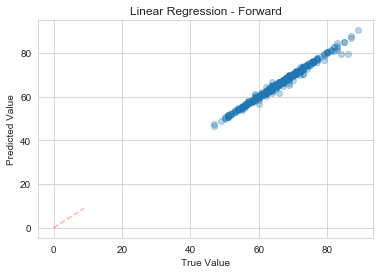


Random Forest Regression - Forward
MAE 0.43249063670411997
RMSE 0.6485623686796944


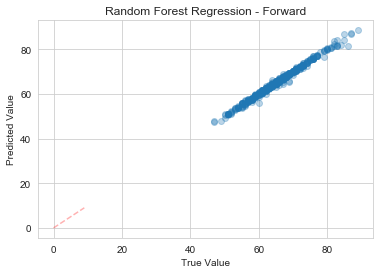


Attacking Midfield:

X_AM_train (800, 101)
y_AM_train (800, 1)
X_AM_test (200, 101)
y_AM_test (200, 1)

Linear Regression - Attacking Midfield
MAE 0.584396480500697
RMSE 2.1313507645795333


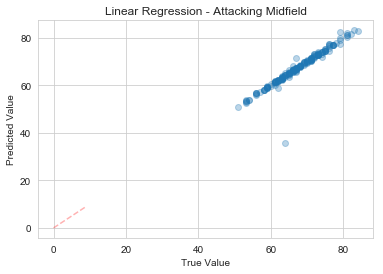


Random Forest Regression - Attacking Midfield
MAE 0.5755500000000001
RMSE 1.249363237813567


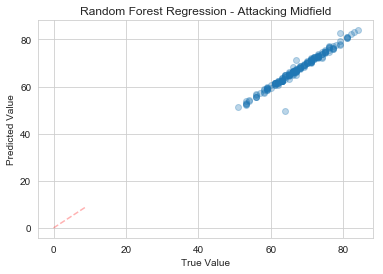


Wings:

X_wings_train (2376, 101)
y_wings_train (2376, 1)
X_wings_test (594, 101)
y_wings_test (594, 1)

Linear Regression - Wings
MAE 0.553509742783188
RMSE 0.817670162694471


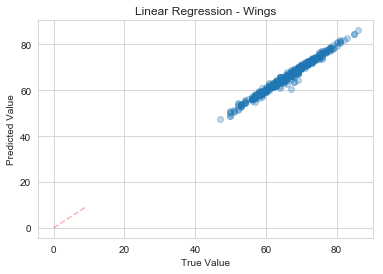


Random Forest Regression - Wings
MAE 0.4216329966329968
RMSE 0.6315907712727464


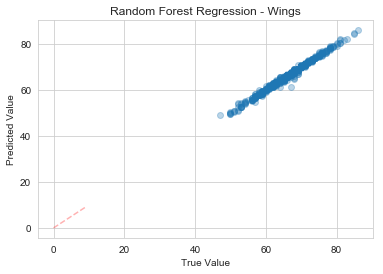


Central Midfield:

X_CM_train (1744, 101)
y_CM_train (1744, 1)
X_CM_test (436, 101)
y_CM_test (436, 1)

Linear Regression - Central Midfield
MAE 0.7718746215694529
RMSE 1.1127093718293688


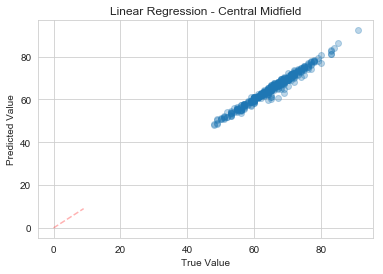


Random Forest Regression - Central Midfield
MAE 0.5397935779816515
RMSE 0.8090356985126738


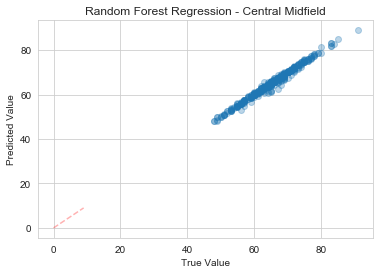


Defensive Midfield:

X_DM_train (1151, 101)
y_DM_train (1151, 1)
X_DM_test (288, 101)
y_DM_test (288, 1)

Linear Regression - Defensive Midfield
MAE 0.8410335392958889
RMSE 1.369056928289057


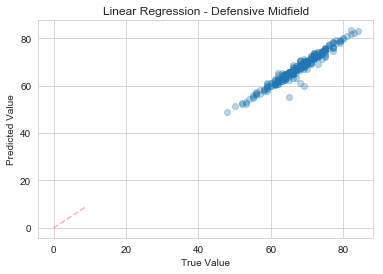


Random Forest Regression - Defensive Midfield
MAE 0.5127777777777779
RMSE 0.7719950705081533


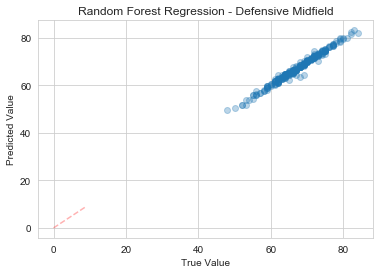


Fullback:

X_fullback_train (2222, 101)
y_fullback_train (2222, 1)
X_fullback_test (556, 101)
y_fullback_test (556, 1)

Linear Regression - Fullback
MAE 0.5012955275370921
RMSE 1.0911991421511398


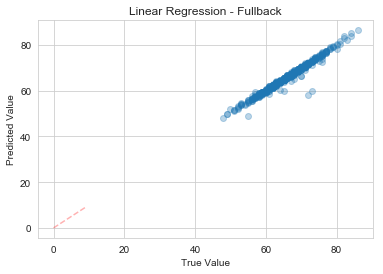


Random Forest Regression - Fullback
MAE 0.45057553956834545
RMSE 0.9846225950465787


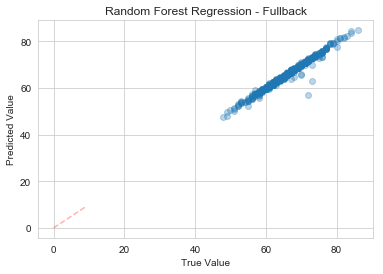


Centre Back:

X_CB_train (2470, 101)
y_CB_train (2470, 1)
X_CB_test (618, 101)
y_CB_test (618, 1)

Linear Regression - Centre Back
MAE 0.32743987516584455
RMSE 0.8980320373292372


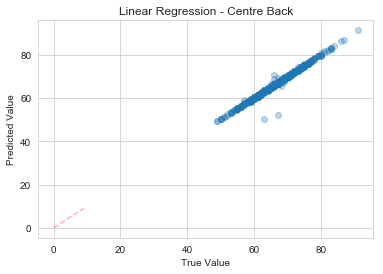


Random Forest Regression - Centre Back
MAE 0.39406148867313917
RMSE 0.9336200726898762


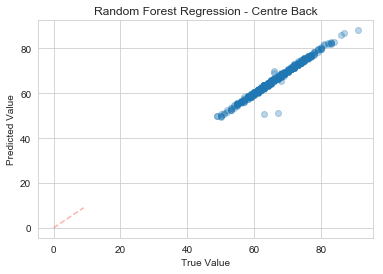


Goalkeeper:

X_GK_train (1151, 101)
y_GK_train (1151, 1)
X_GK_test (288, 101)
y_GK_test (288, 1)

Linear Regression - Goalkeeper
MAE 0.27238865825217823
RMSE 0.3201877810047625


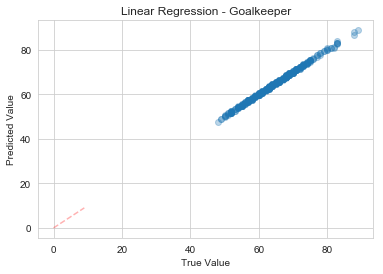


Random Forest Regression - Goalkeeper
MAE 0.523851851851852
RMSE 0.7913885281384461


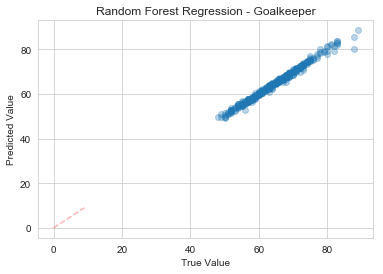

In [10]:
# Forward
X_fw_train, X_fw_test, y_fw_train, y_fw_test = train_test_split(X_fw, y_fw, test_size=1.0-threshold, shuffle=True)

print('Forward:')
print('')
print('X_forward_train', X_fw_train.shape)
print('y_forward_train', y_fw_train.shape)
print('X_forward_test', X_fw_test.shape)
print('y_forward_test', y_fw_test.shape)
print('')

fw_LinReg_model, fw_LinReg_pred = run_experiment('Linear Regression - Forward', LinearRegression(), X_fw_train, y_fw_train, X_fw_test, y_fw_test)
fw_RF_model, fw_RF_pred = run_experiment('Random Forest Regression - Forward', RandomForestRegressor(100), X_fw_train, y_fw_train.values.ravel(), X_fw_test, y_fw_test)

# Attacking Midfield
X_am_train, X_am_test, y_am_train, y_am_test = train_test_split(X_am, y_am, test_size=1.0-threshold, shuffle=True)

print('Attacking Midfield:')
print('')
print('X_AM_train', X_am_train.shape)
print('y_AM_train', y_am_train.shape)
print('X_AM_test', X_am_test.shape)
print('y_AM_test', y_am_test.shape)
print('')

am_LinReg_model, am_LinReg_pred = run_experiment('Linear Regression - Attacking Midfield', LinearRegression(), X_am_train, y_am_train, X_am_test, y_am_test)
am_RF_model, am_RF_pred = run_experiment('Random Forest Regression - Attacking Midfield', RandomForestRegressor(100), X_am_train, y_am_train.values.ravel(), X_am_test, y_am_test)

# Wings
X_wings_train, X_wings_test, y_wings_train, y_wings_test = train_test_split(X_wings, y_wings, test_size=1.0-threshold, shuffle=True)

print('Wings:')
print('')
print('X_wings_train', X_wings_train.shape)
print('y_wings_train', y_wings_train.shape)
print('X_wings_test', X_wings_test.shape)
print('y_wings_test', y_wings_test.shape)
print('')

wings_LinReg_model, wings_LinReg_pred = run_experiment('Linear Regression - Wings', LinearRegression(), X_wings_train, y_wings_train, X_wings_test, y_wings_test)
wings_RF_model, wings_RF_pred = run_experiment('Random Forest Regression - Wings', RandomForestRegressor(100), X_wings_train, y_wings_train.values.ravel(), X_wings_test, y_wings_test)

# Central Midfield
X_cm_train, X_cm_test, y_cm_train, y_cm_test = train_test_split(X_cm, y_cm, test_size=1.0-threshold, shuffle=True)

print('Central Midfield:')
print('')
print('X_CM_train', X_cm_train.shape)
print('y_CM_train', y_cm_train.shape)
print('X_CM_test', X_cm_test.shape)
print('y_CM_test', y_cm_test.shape)
print('')

cm_LinReg_model, cm_LinReg_pred = run_experiment('Linear Regression - Central Midfield', LinearRegression(), X_cm_train, y_cm_train, X_cm_test, y_cm_test)
cm_RF_model, cm_RF_pred = run_experiment('Random Forest Regression - Central Midfield', RandomForestRegressor(100), X_cm_train, y_cm_train.values.ravel(), X_cm_test, y_cm_test)

# Defensive Midfield
X_dm_train, X_dm_test, y_dm_train, y_dm_test = train_test_split(X_dm, y_dm, test_size=1.0-threshold, shuffle=True)

print('Defensive Midfield:')
print('')
print('X_DM_train', X_dm_train.shape)
print('y_DM_train', y_dm_train.shape)
print('X_DM_test', X_dm_test.shape)
print('y_DM_test', y_dm_test.shape)
print('')

dm_LinReg_model, dm_LinReg_pred = run_experiment('Linear Regression - Defensive Midfield', LinearRegression(), X_dm_train, y_dm_train, X_dm_test, y_dm_test)
dm_RF_model, dm_RF_pred = run_experiment('Random Forest Regression - Defensive Midfield', RandomForestRegressor(100), X_dm_train, y_dm_train.values.ravel(), X_dm_test, y_dm_test)

# Fullback
X_fullback_train, X_fullback_test, y_fullback_train, y_fullback_test = train_test_split(X_fullback, y_fullback, test_size=1.0-threshold, shuffle=True)

print('Fullback:')
print('')
print('X_fullback_train', X_fullback_train.shape)
print('y_fullback_train', y_fullback_train.shape)
print('X_fullback_test', X_fullback_test.shape)
print('y_fullback_test', y_fullback_test.shape)
print('')

fullback_LinReg_model, fullback_LinReg_pred = run_experiment('Linear Regression - Fullback', LinearRegression(), X_fullback_train, y_fullback_train, X_fullback_test, y_fullback_test)
fullback_RF_model, fullback_RF_pred = run_experiment('Random Forest Regression - Fullback', RandomForestRegressor(100), X_fullback_train, y_fullback_train.values.ravel(), X_fullback_test, y_fullback_test)

# Centre Back
X_cb_train, X_cb_test, y_cb_train, y_cb_test = train_test_split(X_cb, y_cb, test_size=1.0-threshold, shuffle=True)

print('Centre Back:')
print('')
print('X_CB_train', X_cb_train.shape)
print('y_CB_train', y_cb_train.shape)
print('X_CB_test', X_cb_test.shape)
print('y_CB_test', y_cb_test.shape)
print('')

cb_LinReg_model, cb_LinReg_pred = run_experiment('Linear Regression - Centre Back', LinearRegression(), X_cb_train, y_cb_train, X_cb_test, y_cb_test)
cb_RF_model, cb_RF_pred = run_experiment('Random Forest Regression - Centre Back', RandomForestRegressor(100), X_cb_train, y_cb_train.values.ravel(), X_cb_test, y_cb_test)

# Goalkeeper
X_gk_train, X_gk_test, y_gk_train, y_gk_test = train_test_split(X_gk, y_gk, test_size=1.0-threshold, shuffle=True)

print('Goalkeeper:')
print('')
print('X_GK_train', X_dm_train.shape)
print('y_GK_train', y_dm_train.shape)
print('X_GK_test', X_dm_test.shape)
print('y_GK_test', y_dm_test.shape)
print('')

gk_LinReg_model, gk_LinReg_pred = run_experiment('Linear Regression - Goalkeeper', LinearRegression(), X_gk_train, y_gk_train, X_gk_test, y_gk_test)
gk_RF_model, gk_RF_pred = run_experiment('Random Forest Regression - Goalkeeper', RandomForestRegressor(100), X_gk_train, y_gk_train.values.ravel(), X_gk_test, y_gk_test)

## Error Analysis
Run error analysis by computing absolute error correlation with features in the model that yielded the lower RMSE.

In [11]:
# Forward
y_fw_test.columns = ['True Value']
y_fw_test['Predicted Value'] = fw_RF_pred

df_fw_error = pd.concat([X_fw_test, y_fw_test], axis=1)
df_fw_error['abs_error'] = abs(df_fw_error['Predicted Value'] - df_fw_error['True Value'])
fw_error = df_fw_error.corr()['abs_error'].sort_values(ascending = False)
fw_error.head()

C:\Users\mdongjun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error                   1.000000
Pos_LF                      0.391058
International Reputation    0.197874
Value                       0.178608
Acceleration                0.157393
Name: abs_error, dtype: float64

In [12]:
# Attacking Midfield
y_am_test.columns = ['True Value']
y_am_test['Predicted Value'] = am_RF_pred

df_am_error = pd.concat([X_am_test, y_am_test], axis=1)
df_am_error['abs_error'] = abs(df_am_error['Predicted Value'] - df_am_error['True Value'])
am_error = df_am_error.corr()['abs_error'].sort_values(ascending = False)
am_error.head()

C:\Users\mdongjun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error     1.000000
DWR_High      0.227689
Weight        0.220246
Strength      0.214202
Aggression    0.208633
Name: abs_error, dtype: float64

In [13]:
# Wings
y_wings_test.columns = ['True Value']
y_wings_test['Predicted Value'] = wings_RF_pred

df_wings_error = pd.concat([X_wings_test, y_wings_test], axis=1)
df_wings_error['abs_error'] = abs(df_wings_error['Predicted Value'] - df_wings_error['True Value'])
wings_error = df_wings_error.corr()['abs_error'].sort_values(ascending = False)
wings_error.head()

C:\Users\mdongjun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error         1.000000
StandingTackle    0.084408
DWR_Medium        0.078997
SlidingTackle     0.074264
AWR_Medium        0.070887
Name: abs_error, dtype: float64

In [14]:
# Central Midfield
y_cm_test.columns = ['True Value']
y_cm_test['Predicted Value'] = cm_RF_pred

df_cm_error = pd.concat([X_cm_test, y_cm_test], axis=1)
df_cm_error['abs_error'] = abs(df_cm_error['Predicted Value'] - df_cm_error['True Value'])
cm_error = df_cm_error.corr()['abs_error'].sort_values(ascending = False)
cm_error.head()

C:\Users\mdongjun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error    1.000000
Pos_RCM      0.214842
Age          0.179076
Pos_LCM      0.153637
DWR_High     0.132977
Name: abs_error, dtype: float64

In [15]:
# Defensive Midfield
y_dm_test.columns = ['True Value']
y_dm_test['Predicted Value'] = dm_RF_pred

df_dm_error = pd.concat([X_dm_test, y_dm_test], axis=1)
df_dm_error['abs_error'] = abs(df_dm_error['Predicted Value'] - df_dm_error['True Value'])
dm_error = df_dm_error.corr()['abs_error'].sort_values(ascending = False)
dm_error.head()

C:\Users\mdongjun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error     1.000000
Pos_RDM       0.181865
Balance       0.144793
DWR_Medium    0.137443
Agility       0.132833
Name: abs_error, dtype: float64

In [16]:
# Fullback
y_fullback_test.columns = ['True Value']
y_fullback_test['Predicted Value'] = fullback_RF_pred

df_fullback_error = pd.concat([X_fullback_test, y_fullback_test], axis=1)
df_fullback_error['abs_error'] = abs(df_fullback_error['Predicted Value'] - df_fullback_error['True Value'])
fullback_error = df_fullback_error.corr()['abs_error'].sort_values(ascending = False)
fullback_error.head()

C:\Users\mdongjun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error    1.000000
Pos_LWB      0.212244
DWR_Low      0.132227
Finishing    0.114949
Height       0.106666
Name: abs_error, dtype: float64

In [17]:
# Centre Back
y_cb_test.columns = ['True Value']
y_cb_test['Predicted Value'] = cb_LinReg_pred

df_cb_error = pd.concat([X_cb_test, y_cb_test], axis=1)
df_cb_error['abs_error'] = abs(df_cb_error['Predicted Value'] - df_cb_error['True Value'])
cb_error = df_cb_error.corr()['abs_error'].sort_values(ascending = False)
cb_error.head()

C:\Users\mdongjun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error      1.000000
Skill Moves    0.186779
Finishing      0.144297
Vision         0.113503
Positioning    0.112908
Name: abs_error, dtype: float64

In [18]:
# Goalkeeper
y_gk_test.columns = ['True Value']
y_gk_test['Predicted Value'] = gk_LinReg_pred

df_gk_error = pd.concat([X_gk_test, y_gk_test], axis=1)
df_gk_error['abs_error'] = abs(df_gk_error['Predicted Value'] - df_gk_error['True Value'])
gk_error = df_gk_error.corr()['abs_error'].sort_values(ascending = False)
gk_error.head()

C:\Users\mdongjun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error                   1.000000
International Reputation    0.241056
Wage                        0.174424
Potential                   0.152582
Stamina                     0.095174
Name: abs_error, dtype: float64

## Revised Models
Instantiate new models without features that do not have a correlation with absolute error (ie. correlation coefficient is nan):

Random Forest Regression - Forward
MAE 0.41271535580524366
RMSE 0.591140743205164


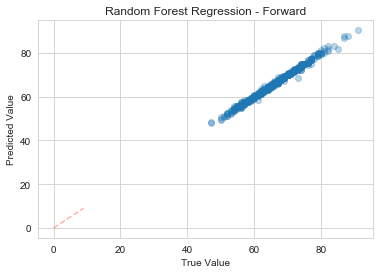

In [27]:
# Forward
X_fw = df_fw[list(set(list(fw_error[fw_error.isna()==False].index)) - set(['True Value', 'Predicted Value', 'abs_error']))]

X_fw_train, X_fw_test, y_fw_train, y_fw_test = train_test_split(X_fw, y_fw, test_size=1.0-threshold, shuffle=True)

fw_LinReg_model, fw_LinReg_pred = run_experiment('Random Forest Regression - Forward', RandomForestRegressor(100), X_fw_train, y_fw_train.values.ravel(), X_fw_test, y_fw_test)

Random Forest Regression - Attacking Midfield
MAE 0.5246999999999999
RMSE 0.7057612910892748


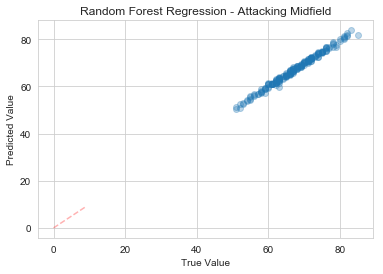

In [28]:
# Attacking Midfield
X_am = df_am[list(set(list(am_error[am_error.isna()==False].index)) - set(['True Value', 'Predicted Value', 'abs_error']))]

X_am_train, X_am_test, y_am_train, y_am_test = train_test_split(X_am, y_am, test_size=1.0-threshold, shuffle=True)

am_RF_model, am_RF_pred = run_experiment('Random Forest Regression - Attacking Midfield', RandomForestRegressor(100), X_am_train, y_am_train.values.ravel(), X_am_test, y_am_test)

Random Forest Regression - Wings
MAE 0.44427609427609416
RMSE 0.7030496340080035


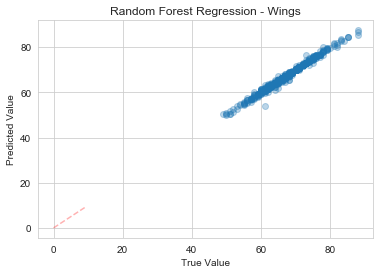

In [29]:
# Wings
X_wings = df_wings[list(set(list(wings_error[wings_error.isna()==False].index)) - set(['True Value', 'Predicted Value', 'abs_error']))]

X_wings_train, X_wings_test, y_wings_train, y_wings_test = train_test_split(X_wings, y_wings, test_size=1.0-threshold, shuffle=True)

wings_RF_model, wings_RF_pred = run_experiment('Random Forest Regression - Wings', RandomForestRegressor(100), X_wings_train, y_wings_train.values.ravel(), X_wings_test, y_wings_test)

Random Forest Regression - Central Midfield
MAE 0.49029816513761476
RMSE 0.6843889995845152


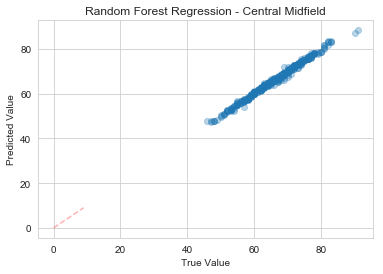

In [30]:
# Central Midfield
X_cm = df_cm[list(set(list(cm_error[cm_error.isna()==False].index)) - set(['True Value', 'Predicted Value', 'abs_error']))]

X_cm_train, X_cm_test, y_cm_train, y_cm_test = train_test_split(X_cm, y_cm, test_size=1.0-threshold, shuffle=True)

cm_RF_model, cm_RF_pred = run_experiment('Random Forest Regression - Central Midfield', RandomForestRegressor(100), X_cm_train, y_cm_train.values.ravel(), X_cm_test, y_cm_test)

Random Forest Regression - Defensive Midfield
MAE 0.45260416666666675
RMSE 0.6337923227156774


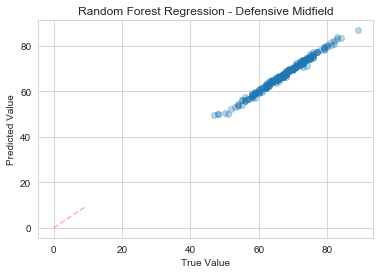

In [31]:
# Defensive Midfield
X_dm = df_dm[list(set(list(dm_error[dm_error.isna()==False].index)) - set(['True Value', 'Predicted Value', 'abs_error']))]

X_dm_train, X_dm_test, y_dm_train, y_dm_test = train_test_split(X_dm, y_dm, test_size=1.0-threshold, shuffle=True)

dm_RF_model, dm_RF_pred = run_experiment('Random Forest Regression - Defensive Midfield', RandomForestRegressor(100), X_dm_train, y_dm_train.values.ravel(), X_dm_test, y_dm_test)

Random Forest Regression - Fullback
MAE 0.4359712230215826
RMSE 0.9303683420014682


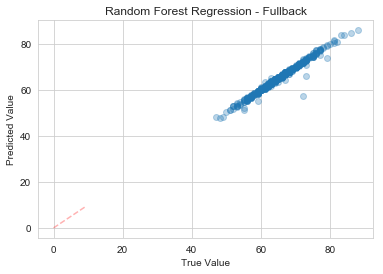

In [32]:
# Fullback
X_fullback = df_fullback[list(set(list(fullback_error[fullback_error.isna()==False].index)) - set(['True Value', 'Predicted Value', 'abs_error']))]

X_fullback_train, X_fullback_test, y_fullback_train, y_fullback_test = train_test_split(X_fullback, y_fullback, test_size=1.0-threshold, shuffle=True)

fullback_RF_model, fullback_RF_pred = run_experiment('Random Forest Regression - Fullback', RandomForestRegressor(100), X_fullback_train, y_fullback_train.values.ravel(), X_fullback_test, y_fullback_test)

Linear Regression - Centre Back
MAE 0.29653604351520346
RMSE 0.4457404369934435


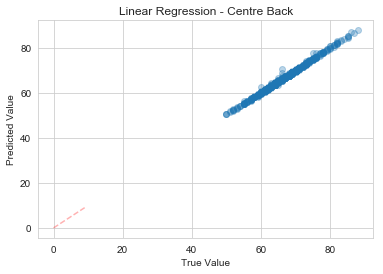

In [33]:
# Centre Back
X_cb = df_cb[list(set(list(cb_error[cb_error.isna()==False].index)) - set(['True Value', 'Predicted Value', 'abs_error']))]

X_cb_train, X_cb_test, y_cb_train, y_cb_test = train_test_split(X_cb, y_cb, test_size=1.0-threshold, shuffle=True)

cb_RF_model, cb_RF_pred = run_experiment('Linear Regression - Centre Back', LinearRegression(), X_cb_train, y_cb_train, X_cb_test, y_cb_test)

Linear Regression - Goalkeeper
MAE 0.26963665875793685
RMSE 0.3150479597538767


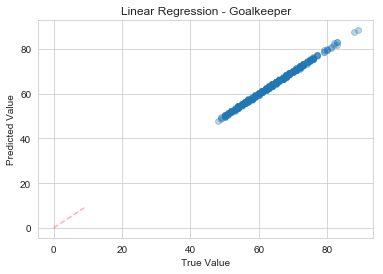

In [34]:
# Goalkeeper
X_gk = df_gk[list(set(list(gk_error[gk_error.isna()==False].index)) - set(['True Value', 'Predicted Value', 'abs_error']))]

X_gk_train, X_gk_test, y_gk_train, y_gk_test = train_test_split(X_gk, y_gk, test_size=1.0-threshold, shuffle=True)

gk_LinReg_model, gk_LinReg_pred = run_experiment('Linear Regression - Goalkeeper', LinearRegression(), X_gk_train, y_gk_train, X_gk_test, y_gk_test)

## Summary
The best performing model for each position group when run again without uncorrelated features resulted in an improved RMSE value with the exception of the wings position group.